    \item ADAPT-VQE method, L-BFGS-B optimizer, Jordan-Wigner mapping, Aer simulator,
    
    \item circuit depth,
    \item gate fidelity,
    \item parameter count,
    \item TRAINABILITY,
    \item EXPRESSIBILITY.

     $H_2$, $He$, $LiH$, $BeH_2$ molecules.

     \item converged ground state energy graph, depending on the inter-atomic distance,
\item accuracy, with reference of FCI calculations, absolute error (\parencite{sims2006high}), depending on the inter-atomic distance,
\item number of iterations needed to achieve convergence (gradient tolerance is $10^{-5}$), depending on the inter-atomic distance,
\item for one inter-atomic distance, graph of convergence,
\item runtime, depending on the inter-atomic distance.

In [18]:
import numpy as np

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_algorithms.minimum_eigensolvers import AdaptVQE, VQE
from qiskit.primitives import Estimator
import time
from matplotlib import pyplot as plt


In [19]:
def run_adapt_vqe(info: MoleculeInfo):
# info = MoleculeInfo(["Li", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5)])
    driver = PySCFDriver.from_molecule(info, basis="sto3g")
    molecule = driver.run()

    transformer = FreezeCoreTransformer()
    molecule = transformer.transform(molecule)

    hamiltonian = molecule.hamiltonian.second_q_op()
    mapper = ParityMapper(num_particles=molecule.num_particles)
    tapered_mapper = molecule.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(hamiltonian)

    init_state = HartreeFock(
        molecule.num_spatial_orbitals,
        molecule.num_particles,
        tapered_mapper,
    )

    optimizer = L_BFGS_B(maxiter=10000, ftol=1e-9)
    estimator = Estimator()

    adapt_vqe_ansatz = UCCSD(
        molecule.num_spatial_orbitals,
        molecule.num_particles,
        tapered_mapper,
        initial_state=init_state,
    )

    adapt_vqe = AdaptVQE(VQE(estimator, adapt_vqe_ansatz, optimizer))
    start = time.perf_counter()
    result_adapt_vqe = adapt_vqe.compute_minimum_eigenvalue(qubit_op)
    end = time.perf_counter()
    return (result_adapt_vqe, end - start)

In [20]:
molecules = [
    ("H2", lambda d: MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, d)])),
    ("LiH", lambda d: MoleculeInfo(["Li", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, d)])),
    ("BeH2", lambda d: MoleculeInfo(["Be", "H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, d), (0.0, 0.0, -d)])),
]

distances=[0.1, 0.2, 0.5, 0.735, 1.0, 1.5, 2.0, 3.0, 4.0]

In [21]:
num_iter=[]
opt_times=[]
runtimes=[]
energies=[]

In [22]:
for i in range(len(distances)):
    (result_adapt_vqe, runtime) = run_adapt_vqe(molecules[0][1](distances[i]))
    num_iter.append(result_adapt_vqe.num_iterations)
    opt_times.append(result_adapt_vqe.optimizer_time)
    runtimes.append(runtime)
    energies.append(result_adapt_vqe.optimizer_result.fun)
    print(f"Distance: {distances[i]} - Iterations: {result_adapt_vqe.num_iterations} - Energy: {result_adapt_vqe.optimizer_result.fun} - Optimizer Time: {result_adapt_vqe.optimizer_time} - Runtime: {runtime}")

/tmp/ipykernel_1945155/1755848209.py:21: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Distance: 0.1 - Iterations: 2 - Energy: -2.5818113383327237 - Optimizer Time: 0.02965521812438965 - Runtime: 0.03821393000544049
Distance: 0.2 - Iterations: 2 - Energy: -2.488403919801636 - Optimizer Time: 0.03742408752441406 - Runtime: 0.05099697699188255
Distance: 0.5 - Iterations: 2 - Energy: -2.113514216310623 - Optimizer Time: 0.031107425689697266 - Runtime: 0.03937136000604369
Distance: 0.735 - Iterations: 2 - Energy: -1.8572750302023782 - Optimizer Time: 0.050922393798828125 - Runtime: 0.06124262700905092
Distance: 1.0 - Iterations: 2 - Energy: -1.630327541152571 - Optimizer Time: 0.04796791076660156 - Runtime: 0.060679895017528906
Distance: 1.5 - Iterations: 2 - Energy: -1.3509341607511838 - Optimizer Time: 0.04029583930969238 - Runtime: 0.04848977201618254
Distance: 2.0 - Iterations: 2 - Energy: -1.2132297176356395 - Optimizer Time: 0.0567929744720459 - Runtime: 0.06398243102012202
Distance: 3.0 - Iterations: 2 - Energy: -1.1100242481593074 - Optimizer Time: 0.0352652072906494

[2, 2, 2, 2, 2, 2, 2, 2, 2]


/tmp/ipykernel_1945155/2026189385.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


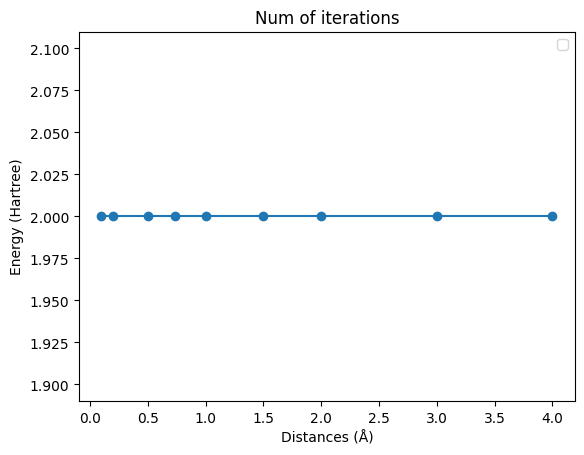

In [23]:
print(num_iter)
plt.plot(distances, num_iter, marker='o', linestyle='-')
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Num of iterations')
plt.show()

[0.02965521812438965, 0.03742408752441406, 0.031107425689697266, 0.050922393798828125, 0.04796791076660156, 0.04029583930969238, 0.0567929744720459, 0.035265207290649414, 0.027993202209472656]


/tmp/ipykernel_1945155/2789551103.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


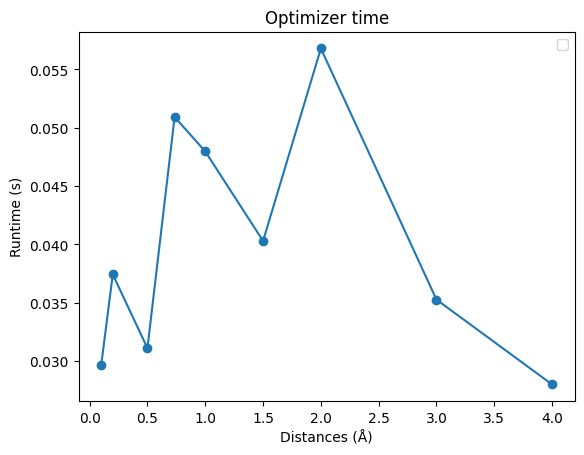

In [24]:
print(opt_times)
plt.plot(distances, opt_times, marker='o', linestyle='-')
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Runtime (s)')
plt.title('Optimizer time')
plt.show()

[0.03821393000544049, 0.05099697699188255, 0.03937136000604369, 0.06124262700905092, 0.060679895017528906, 0.04848977201618254, 0.06398243102012202, 0.0402004599745851, 0.03336154800490476]


/tmp/ipykernel_1945155/3072216357.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


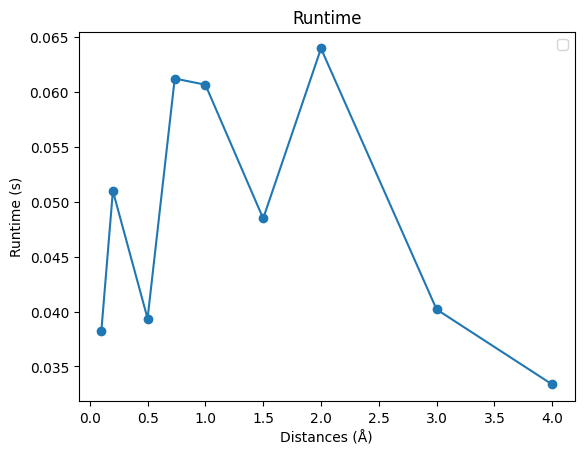

In [25]:
print(runtimes)
plt.plot(distances, runtimes, marker='o', linestyle='-')
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Runtime (s)')
plt.title('Runtime')
plt.show()

[np.float64(-2.5818113383327237), np.float64(-2.488403919801636), np.float64(-2.113514216310623), np.float64(-1.8572750302023782), np.float64(-1.630327541152571), np.float64(-1.3509341607511838), np.float64(-1.2132297176356395), np.float64(-1.1100242481593074), np.float64(-1.0654656645451264)]


/tmp/ipykernel_1945155/4127808851.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


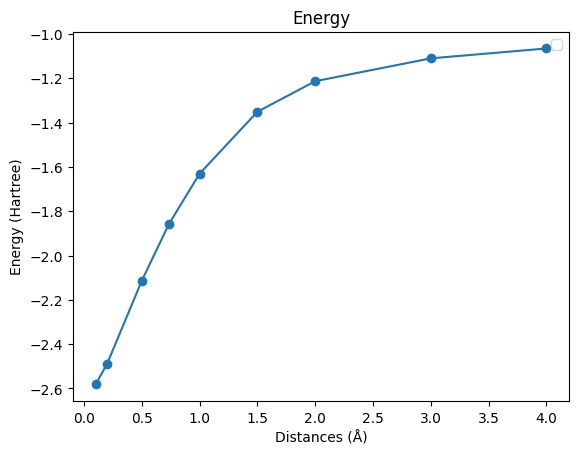

In [26]:
print(energies)
plt.plot(distances, energies, marker='o', linestyle='-')
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy')
plt.show()

In [27]:
num_iter=[]
opt_time=[]
energies=[]

In [28]:
for i in range(len(distances)):
    (result_adapt_vqe, runtime) = run_adapt_vqe(molecules[1][1](distances[i]))
    num_iter.append(result_adapt_vqe.num_iterations)
    opt_times.append(result_adapt_vqe.optimizer_time)
    runtimes.append(runtime)
    energies.append(result_adapt_vqe.optimizer_result.fun)
    print(f"Distance: {distances[i]} - Iterations: {result_adapt_vqe.num_iterations} - Energy: {result_adapt_vqe.optimizer_result.fun} - Optimizer Time: {result_adapt_vqe.optimizer_time} - Runtime: {runtime}")

/tmp/ipykernel_1945155/1755848209.py:21: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Distance: 0.1 - Iterations: 11 - Energy: -0.9575002517408583 - Optimizer Time: 7.599501848220825 - Runtime: 41.95097169899964
Distance: 0.2 - Iterations: 11 - Energy: -0.9279088894659918 - Optimizer Time: 9.648284912109375 - Runtime: 54.755986183998175
Distance: 0.5 - Iterations: 11 - Energy: -0.9874449054942488 - Optimizer Time: 10.416940450668335 - Runtime: 47.73227245200542
Distance: 0.735 - Iterations: 9 - Energy: -1.1258855800620267 - Optimizer Time: 7.066250324249268 - Runtime: 34.52891978799016
Distance: 1.0 - Iterations: 9 - Energy: -1.1742345538695922 - Optimizer Time: 5.727841138839722 - Runtime: 31.71293575601885
Distance: 1.5 - Iterations: 10 - Energy: -1.1001795361250646 - Optimizer Time: 4.481294631958008 - Runtime: 38.05666062099044
Distance: 2.0 - Iterations: 11 - Energy: -0.9904135795826925 - Optimizer Time: 7.517265319824219 - Runtime: 44.26272849799716
Distance: 3.0 - Iterations: 11 - Energy: -0.8396276373175492 - Optimizer Time: 11.984248638153076 - Runtime: 54.3300

In [29]:
print(num_iter)
print(opt_times)
print(runtimes)
print(energies)

[11, 11, 11, 9, 9, 10, 11, 11, 8]
[0.02965521812438965, 0.03742408752441406, 0.031107425689697266, 0.050922393798828125, 0.04796791076660156, 0.04029583930969238, 0.0567929744720459, 0.035265207290649414, 0.027993202209472656, 7.599501848220825, 9.648284912109375, 10.416940450668335, 7.066250324249268, 5.727841138839722, 4.481294631958008, 7.517265319824219, 11.984248638153076, 4.618098020553589]
[0.03821393000544049, 0.05099697699188255, 0.03937136000604369, 0.06124262700905092, 0.060679895017528906, 0.04848977201618254, 0.06398243102012202, 0.0402004599745851, 0.03336154800490476, 41.95097169899964, 54.755986183998175, 47.73227245200542, 34.52891978799016, 31.71293575601885, 38.05666062099044, 44.26272849799716, 54.33006294298684, 27.969268604007084]
[np.float64(-0.9575002517408583), np.float64(-0.9279088894659918), np.float64(-0.9874449054942488), np.float64(-1.1258855800620267), np.float64(-1.1742345538695922), np.float64(-1.1001795361250646), np.float64(-0.9904135795826925), np.fl

In [30]:
num_iter=[]
opt_time=[]
energies=[]

In [31]:
for i in range(len(distances)):
    (result_adapt_vqe, runtime) = run_adapt_vqe(molecules[2][1](distances[i]))
    num_iter.append(result_adapt_vqe.num_iterations)
    opt_times.append(result_adapt_vqe.optimizer_time)
    runtimes.append(runtime)
    energies.append(result_adapt_vqe.optimizer_result.fun)
    print(f"Distance: {distances[i]} - Iterations: {result_adapt_vqe.num_iterations} - Energy: {result_adapt_vqe.optimizer_result.fun} - Optimizer Time: {result_adapt_vqe.optimizer_time} - Runtime: {runtime}")

/tmp/ipykernel_1945155/1755848209.py:21: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Distance: 0.1 - Iterations: 17 - Energy: -5.142260481477643 - Optimizer Time: 6.324145317077637 - Runtime: 79.01601827002014
Distance: 0.2 - Iterations: 16 - Energy: -5.193126813213986 - Optimizer Time: 4.700140714645386 - Runtime: 71.72644568700343
Distance: 0.5 - Iterations: 19 - Energy: -5.026473131657737 - Optimizer Time: 7.067937612533569 - Runtime: 99.23219260497717
Distance: 0.735 - Iterations: 17 - Energy: -4.791074703779565 - Optimizer Time: 7.672454595565796 - Runtime: 85.53832248799154
Distance: 1.0 - Iterations: 17 - Energy: -4.423492232342608 - Optimizer Time: 6.710353136062622 - Runtime: 84.55502803099807
Distance: 1.5 - Iterations: 17 - Energy: -3.7230335955303 - Optimizer Time: 7.201664686203003 - Runtime: 82.94143104899558
Distance: 2.0 - Iterations: 20 - Energy: -3.1948979038149927 - Optimizer Time: 46.346221685409546 - Runtime: 196.82583333199727
Distance: 3.0 - Iterations: 27 - Energy: -2.6905354551867613 - Optimizer Time: 125.42274832725525 - Runtime: 745.583824867

In [32]:
print(num_iter)
print(opt_times)
print(runtimes)
print(energies)

[17, 16, 19, 17, 17, 17, 20, 27, 10]
[0.02965521812438965, 0.03742408752441406, 0.031107425689697266, 0.050922393798828125, 0.04796791076660156, 0.04029583930969238, 0.0567929744720459, 0.035265207290649414, 0.027993202209472656, 7.599501848220825, 9.648284912109375, 10.416940450668335, 7.066250324249268, 5.727841138839722, 4.481294631958008, 7.517265319824219, 11.984248638153076, 4.618098020553589, 6.324145317077637, 4.700140714645386, 7.067937612533569, 7.672454595565796, 6.710353136062622, 7.201664686203003, 46.346221685409546, 125.42274832725525, 4.028911590576172]
[0.03821393000544049, 0.05099697699188255, 0.03937136000604369, 0.06124262700905092, 0.060679895017528906, 0.04848977201618254, 0.06398243102012202, 0.0402004599745851, 0.03336154800490476, 41.95097169899964, 54.755986183998175, 47.73227245200542, 34.52891978799016, 31.71293575601885, 38.05666062099044, 44.26272849799716, 54.33006294298684, 27.969268604007084, 79.01601827002014, 71.72644568700343, 99.23219260497717, 85.5